In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VECM
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.vector_ar.vecm import coint_johansen as v_coint
from statsmodels.tsa.vector_ar.vecm import select_coint_rank as coint_rank

In [2]:
#LOAD DATASET
crude = pd.read_csv("Daily Crude Oil Price.csv")
refined = pd.read_csv("daily refined products price.csv")
monthly_crude = pd.read_csv("Monthly Crude Oil Price.csv")
monthly_refined = pd.read_csv("Monthly Refined Products.csv")

In [3]:
monthly_crude.head(10)

,Date,WTI PRICE,BRENT PRICE,BONNY LIGHT PRICE
0,"Jan, 2010",74.41,68.40,76.37
1,"Feb, 2010",72.57,70.06,74.31
2,"Mar, 2010",81.20,78.83,79.27
3,"Apr, 2010",80.46,80.96,84.93
4,"May,2010",73.76,75.81,76.25
5,"Jun, 2010",75.34,74.76,74.84
6,"Jul, 2010",72.85,72.14,74.74
7,"Aug, 2010",76.60,77.04,76.69
8,"Sep, 2010",71.82,74.30,77.79
9,"Oct, 2010",81.89,82.66,82.92


In [4]:
crude.head()

,Date,WTI PRICE,BRENT PRICE,BONNY LIGHT PRICE
0,"Jan 04, 2010",81.52,79.05,80.30
1,"Jan 05, 2010",81.74,0.00,80.21
2,"Jan 06, 2010",83.12,80.14,81.97
3,"Jan 07, 2010",82.60,80.57,80.94
4,"Jan 08, 2010",82.74,80.06,80.77


In [5]:
refined.head()

,Date,Diesel,Jet Fuel,Heating Oil,Gasoline
0,4-Jan-10,2.21,2.17,2.18,2.22
1,5-Jan-10,2.19,2.17,2.19,2.19
2,6-Jan-10,2.20,2.17,2.20,2.20
3,7-Jan-10,2.18,2.17,2.17,2.16
4,8-Jan-10,2.19,2.16,2.19,2.18


In [3]:
#DATA CLEANING
monthly_refined.columns = ['Date', 'Diesel', 'Jet Fuel', 'Heating Oil', 'Gasoline']
refined.columns= ['Date', 'Diesel', 'Jet Fuel', 'Heating Oil', 'Gasoline']


#REPLACE ZEROS WITH PREVIOUS DAY OR MONTHS VALUE FOR CRUDE
crude['BRENT PRICE']=crude['BRENT PRICE'].mask(crude['BRENT PRICE']==0.0).ffill()
crude['WTI PRICE']=crude['WTI PRICE'].mask(crude['WTI PRICE']==0.0).ffill()
crude['BONNY LIGHT PRICE']=crude['BONNY LIGHT PRICE'].mask(crude['BONNY LIGHT PRICE']==0.0).ffill()
monthly_crude['BONNY LIGHT PRICE']=monthly_crude['BONNY LIGHT PRICE'].mask(monthly_crude['BONNY LIGHT PRICE']==0.0).ffill()
monthly_crude['WTI PRICE']=monthly_crude['WTI PRICE'].mask(monthly_crude['WTI PRICE']==0.0).ffill()
monthly_crude['WTI PRICE']=monthly_crude['BRENT PRICE'].mask(monthly_crude['BRENT PRICE']==0.0).ffill()

#REPLACE ZEROS WITH PREVIOUS DAY OR MONTHS VALUE FOR REFINED PRODUCTS
refined['Diesel']=refined['Diesel'].mask(refined['Diesel']==0.0).ffill()
refined['Jet Fuel']=refined['Jet Fuel'].mask(refined['Jet Fuel']==0.0).ffill()
refined['Heating Oil']=refined['Heating Oil'].mask(refined['Heating Oil']==0.0).ffill()
refined['Gasoline']=refined['Gasoline'].mask(refined['Gasoline']==0.0).ffill()

monthly_refined['Diesel']=monthly_refined['Diesel'].mask(monthly_refined['Diesel']==0.0).ffill()
monthly_refined['Jet Fuel']=monthly_refined['Jet Fuel'].mask(monthly_refined['Jet Fuel']==0.0).ffill()
monthly_refined['Heating Oil']=monthly_refined['Heating Oil'].mask(monthly_refined['Heating Oil']==0.0).ffill()
monthly_refined['Gasoline']=monthly_refined['Gasoline'].mask(monthly_refined['Gasoline']==0.0).ffill()

In [4]:
#PREPARE DATSETS FOR EACH CRUDE TYPE

#create WTI AND REFINED PRODUCTS DATAFRAME
refined['WTI_PRICE'] = crude['WTI PRICE']
WTI = refined.copy()
del refined['WTI_PRICE']

#create BRENT AND REFINED PRODUCTS DATAFRAME
refined['BRENT_PRICE'] = crude['BRENT PRICE']
BRENT = refined.copy()
del refined['BRENT_PRICE']

#create BONNY LIGHT AND REFINED PRODUCTS DATAFRAME
refined['BONNY_PRICE'] = crude['BONNY LIGHT PRICE']
BONNY = refined.copy()
del refined['BONNY_PRICE']


#create MONTHLY WTI AND REFINED PRODUCTS DATAFRAME
monthly_refined['WTI_PRICE'] = monthly_crude['WTI PRICE']
monthly_WTI = monthly_refined.copy()
del monthly_refined['WTI_PRICE']

#create MONTHLY BRENT AND REFINED PRODUCTS DATAFRAME
monthly_refined['BRENT_PRICE'] = monthly_crude['BRENT PRICE']
monthly_BRENT = monthly_refined.copy()
del monthly_refined['BRENT_PRICE']

#create MONTHLY BONNY LIGHT AND REFINED PRODUCTS DATAFRAME
monthly_refined['BONNY_PRICE'] = monthly_crude['BONNY LIGHT PRICE']
monthly_BONNY = monthly_refined.copy()
del monthly_refined['BONNY_PRICE']

In [5]:
crude.head()

,Date,WTI PRICE,BRENT PRICE,BONNY LIGHT PRICE
0,"Jan 04, 2010",81.52,79.05,80.30
1,"Jan 05, 2010",81.74,79.05,80.21
2,"Jan 06, 2010",83.12,80.14,81.97
3,"Jan 07, 2010",82.60,80.57,80.94
4,"Jan 08, 2010",82.74,80.06,80.77


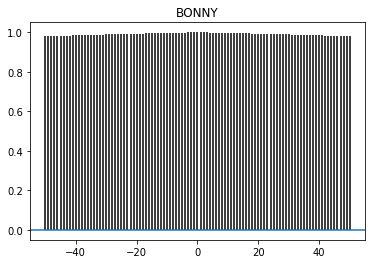

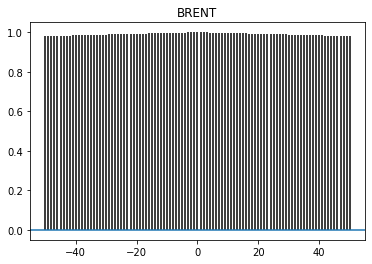

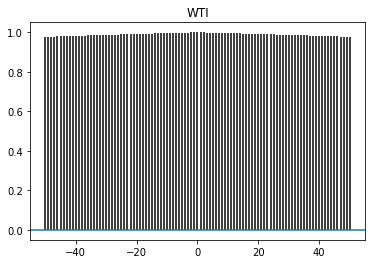

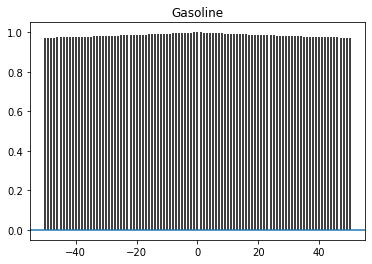

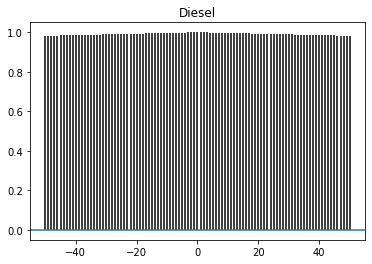

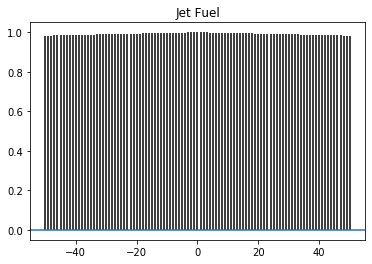

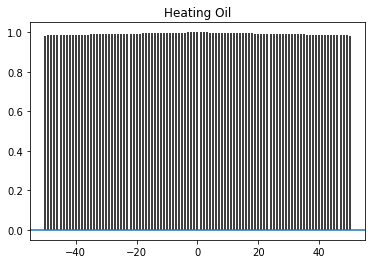

In [5]:
#AUTO CORRELATION FUNTION TO CHECK FOR STATIONARITY
plt_b = plt.acorr(BONNY['BONNY_PRICE'], maxlags=50)
plt.title('BONNY')
plt.show()
plt.acorr(BRENT['BRENT_PRICE'], maxlags=50)
plt.title('BRENT')
plt.show()
plt.acorr(WTI['WTI_PRICE'], maxlags=50)
plt.title('WTI')
plt.show()
plt.acorr(BONNY['Gasoline'], maxlags=50)
plt.title('Gasoline')
plt.show()
plt.acorr(BONNY['Diesel'], maxlags=50)
plt.title('Diesel')
plt.show()
plt.acorr(BONNY['Jet Fuel'], maxlags=50)
plt.title('Jet Fuel')
plt.show()
plt.acorr(BONNY['Heating Oil'], maxlags=50)
plt.title('Heating Oil')
plt.show()

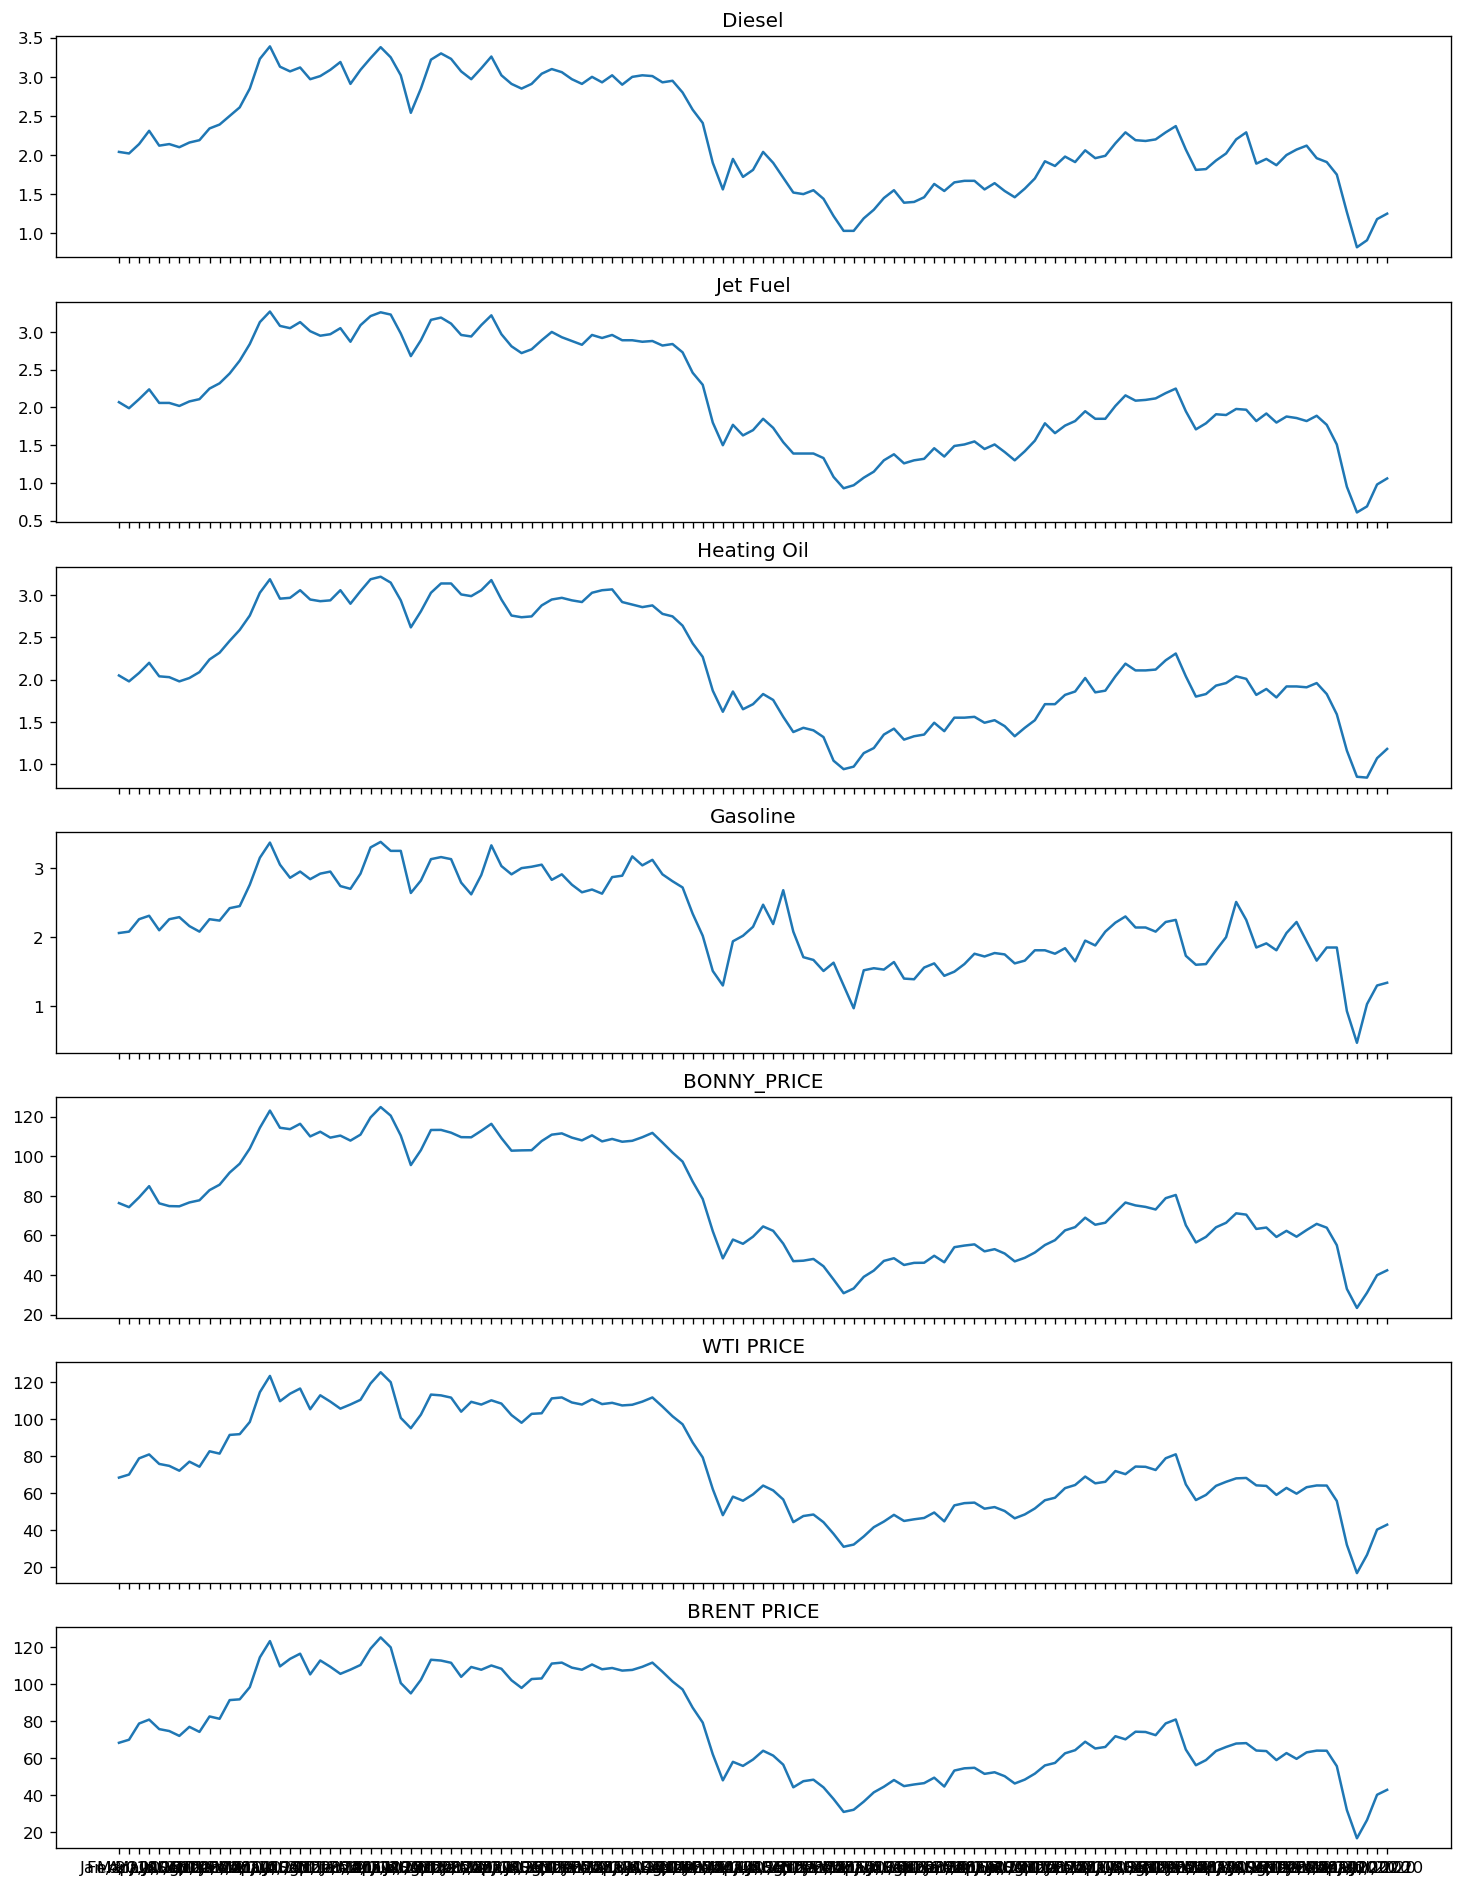

In [26]:
# VISUALIZE BONNY AGAINST REFINNED PROD
fig, axes = plt.subplots(nrows=7, ncols=1, sharex = 'col' , sharey= 'row' ,dpi=120, figsize=(15,20))
axes[0].plot(monthly_BONNY['Date'], monthly_BONNY['Diesel'])
axes[0].set_title('Diesel')
axes[1].plot(monthly_BONNY['Date'], monthly_BONNY['Jet Fuel'])
axes[1].set_title('Jet Fuel')
axes[2].plot(monthly_BONNY['Date'], monthly_BONNY['Heating Oil'])
axes[2].set_title('Heating Oil')
axes[3].plot(monthly_BONNY['Date'], monthly_BONNY['Gasoline'])
axes[3].set_title('Gasoline')
axes[4].plot(monthly_BONNY['Date'], monthly_BONNY['BONNY_PRICE'])
axes[4].set_title('BONNY_PRICE')
axes[5].plot(monthly_WTI['Date'], monthly_WTI['WTI_PRICE'])
axes[5].set_title('WTI PRICE')
axes[6].plot(monthly_BRENT['Date'], monthly_BRENT['BRENT_PRICE'])
axes[6].set_title('BRENT PRICE')
plt.show()

In [6]:
#ADF STATIONARITY TEST RESULTS

print('ADF STATIONARITY TEST RESULTS')
for price in ['Diesel', 'Jet Fuel', 'Heating Oil', 'Gasoline', 'BONNY_PRICE']:
    adf_res = adfuller(BONNY[price], autolag='AIC')
    print( '\n'+price+'\n', pd.Series(adf_res[0:4], index=['Test Statistics', 'P-Value', 'Number of lags used', 'Number of observation used'])) 
adf_res = adfuller(BRENT['BRENT_PRICE'], autolag='AIC')
adf_BRENT = pd.Series(adf_res[0:4], index=['Test Statistics', 'P-Value', 'Number of lags used', 'Number of observation used'])
adf_res = adfuller(WTI['WTI_PRICE'], autolag='AIC')
adf_WTI = pd.Series(adf_res[0:4], index=['Test Statistics', 'P-Value', 'Number of lags used', 'Number of observation used'])  
print('\nBRENT\n' ,adf_BRENT )
print('\nWTI\n' ,adf_WTI )

ADF STATIONARITY TEST RESULTS

Diesel
 Test Statistics                 -1.533892
P-Value                          0.516684
Number of lags used              8.000000
Number of observation used    2635.000000
dtype: float64

Jet Fuel
 Test Statistics                 -0.880030
P-Value                          0.794478
Number of lags used              2.000000
Number of observation used    2641.000000
dtype: float64

Heating Oil
 Test Statistics                 -0.988221
P-Value                          0.757536
Number of lags used              1.000000
Number of observation used    2642.000000
dtype: float64

Gasoline
 Test Statistics                 -2.450772
P-Value                          0.127916
Number of lags used             26.000000
Number of observation used    2617.000000
dtype: float64

BONNY_PRICE
 Test Statistics                 -1.138784
P-Value                          0.699360
Number of lags used              1.000000
Number of observation used    2642.000000
dtype: floa

In [7]:
# REMOVE DATA COLUMN
del BONNY['Date']
del BRENT['Date']
del WTI['Date']

In [18]:
#MODEL VAR
model_BONNY = VAR((BONNY))
model_BRENT = VAR((BRENT))
model_WTI = VAR((WTI))

BONNY_results = model_BONNY.fit(trend='c', maxlags=15,  ic='aic')
BRENT_results = model_BRENT.fit(trend='c', maxlags=15,  ic='aic')
WTI_results = model_WTI.fit(trend='c', maxlags=15,  ic='aic')

variables = ['Diesel','Jet Fuel','Heating Oil','Gasoline',['Diesel','Jet Fuel'],['Diesel','Heating Oil'],['Diesel','Gasoline'],['Jet Fuel','Heating Oil'],['Jet Fuel','Gasoline'],['Heating Oil','Gasoline'],['Diesel','Jet Fuel','Heating Oil'],['Diesel','Jet Fuel','Gasoline'],['Diesel','Heating Oil','Gasoline'],['Heating Oil','Jet Fuel','Gasoline'],['Diesel','Jet Fuel','Heating Oil','Gasoline']]
regions = ['BONNY_PRICE','BRENT_PRICE','WTI_PRICE']
results = [BONNY_results,BRENT_results,WTI_results]

In [19]:
# CHECK FOR CAUSALITY USING GRANGER CAUSALITY

for i in range(len(regions)):
    print('CRUDE TYPE :', regions[i])
    for k in variables:
        granger_output= results[i].test_causality(regions[i], k)
        print(k  ,granger_output.pvalue )
    print('\n\n')

CRUDE TYPE : BONNY_PRICE
Diesel 0.3619406327869857
Jet Fuel 0.2360381656891943
Heating Oil 0.32538700805958304
Gasoline 0.2415301509235954
['Diesel', 'Jet Fuel'] 0.26726461104061017
['Diesel', 'Heating Oil'] 0.17495774786466706
['Diesel', 'Gasoline'] 0.3903325758832139
['Jet Fuel', 'Heating Oil'] 0.24160493367729646
['Jet Fuel', 'Gasoline'] 0.14573508385122294
['Heating Oil', 'Gasoline'] 0.1817899635064653
['Diesel', 'Jet Fuel', 'Heating Oil'] 0.00011986169998824075
['Diesel', 'Jet Fuel', 'Gasoline'] 0.17368641024253453
['Diesel', 'Heating Oil', 'Gasoline'] 0.18353357429732978
['Heating Oil', 'Jet Fuel', 'Gasoline'] 0.12496125067337911
['Diesel', 'Jet Fuel', 'Heating Oil', 'Gasoline'] 6.265102369625059e-07



CRUDE TYPE : BRENT_PRICE
Diesel 0.611190482097205
Jet Fuel 0.5261085660220828
Heating Oil 0.41667865328228637
Gasoline 0.6987691259857267
['Diesel', 'Jet Fuel'] 0.28792147534628126
['Diesel', 'Heating Oil'] 0.283148449313213
['Diesel', 'Gasoline'] 0.8387777638807391
['Jet Fuel', '

In [8]:
#CHECK FOR COINTEGRATION
vec_renk_trace = v_coint(BONNY, det_order=1, k_ar_diff=1)
print(vec_renk_trace.trace_stat)
print(vec_renk_trace.trace_stat_crit_vals)
print(vec_renk_trace.max_eig_stat)
print(vec_renk_trace.max_eig_stat_crit_vals)
#max_eig_stat and max_eig_stat_crit_vals
v_rank = coint_rank(BONNY, det_order=1, k_ar_diff=3, method='maxeig')
v_rank.summary()

[392.3355701  218.89996231 105.06435676  43.21236395   3.72764811]
[[75.1027 79.3422 87.7748]
 [51.6492 55.2459 62.5202]
 [32.0645 35.0116 41.0815]
 [16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]
[173.43560779 113.83560556  61.8519928   39.48471584   3.72764811]
[[34.4202 37.1646 42.8612]
 [28.2398 30.8151 36.193 ]
 [21.8731 24.2522 29.2631]
 [15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]]


r_0,r_1,test statistic,critical value
0,1,96.48,37.16
1,2,84.90,30.82
2,3,54.93,24.25
3,4,37.74,17.15
4,5,3.463,3.841


In [21]:
#BUILD VECM MODEL

BONNY_train = BONNY[0:-10]
BONNY_test = BONNY[-10:]

BRENT_train = BRENT[0:-10]
BRENT_test = BRENT[-10:]

WTI_train = WTI[0:-10]
WTI_test = WTI[-10:]
lag_order = BONNY_results.k_ar -1
vecm_bonny=VECM(BONNY_train, coint_rank=4, k_ar_diff =lag_order, deterministic='cili' )
bonny_model = vecm_bonny.fit()
bonny_pred=bonny_model.predict(steps=10)

vecm_brent=VECM(BRENT_train, coint_rank=4, k_ar_diff =lag_order, deterministic='cili' )
brent_model = vecm_brent.fit()
brent_pred = brent_model.predict(steps=10)


vecm_wti=VECM(WTI_train, coint_rank=4, k_ar_diff =lag_order, deterministic='cili' )
wti_model = vecm_wti.fit()
wti_pred = wti_model.predict(steps=10)

#print(bonny_pred)
#print(brent_pred)
#print(wti_pred)


#TESTING MODLES' PERFORMANCE 
bonny_rmse = np.sqrt(np.sum(np.abs(bonny_pred - BONNY_test)))
print('BONNY ROOT MEAN SQUARE ERROR :', bonny_rmse['BONNY_PRICE'])

brent_rmse = np.sqrt(np.sum(np.abs(brent_pred - BRENT_test)))
print('BRENT ROOT MEAN SQUARE ERROR :', brent_rmse['BRENT_PRICE'])

wti_rmse = np.sqrt(np.sum(np.abs(wti_pred - WTI_test)))
print('WTI ROOT MEAN SQUARE ERROR :',wti_rmse['WTI_PRICE'])

BONNY ROOT MEAN SQUARE ERROR : 6.060622505371369
BRENT ROOT MEAN SQUARE ERROR : 5.925230542137318
WTI ROOT MEAN SQUARE ERROR : 5.345439061897298


In [10]:
#print('ALPHA',bonny_model.alpha)
#print('BETA',bonny_model.beta)
#print('GAMMA',bonny_model.gamma)
#print('SIGMA U',bonny_model.sigma_u)
#print('DELTA Y1 T',bonny_model._delta_y_1_T)
#print('Y_LAG_1',bonny_model._y_lag1)
#print('_DELTA X',bonny_model._delta_x)
#print('RESIDUAL',bonny_model.resid)


In [11]:
#ADF STATIONARITY TEST FOR THE MODELS' RETURN SERIES
delta_y_t = bonny_model._delta_y_1_T
labels = ['Diesel', 'Jet Fuel', 'Heating Oil', 'Gasoline', 'BONNY_PRICE']
for g in range(len(['Diesel', 'Jet Fuel', 'Heating Oil', 'Gasoline', 'BONNY_PRICE'])):
    adf_vecm = adfuller(delta_y_t[g], autolag='AIC')
    print( '\n'+labels[g]+'\n', pd.Series(adf_vecm[0:4], index=['Test Statistics', 'P-Value', 'Number of lags used', 'Number of observation used'])) 



Diesel
 Test Statistics              -1.619584e+01
P-Value                       4.125326e-29
Number of lags used           7.000000e+00
Number of observation used    2.622000e+03
dtype: float64

Jet Fuel
 Test Statistics                -37.871801
P-Value                          0.000000
Number of lags used              1.000000
Number of observation used    2628.000000
dtype: float64

Heating Oil
 Test Statistics                -53.574639
P-Value                          0.000000
Number of lags used              0.000000
Number of observation used    2629.000000
dtype: float64

Gasoline
 Test Statistics              -1.095526e+01
P-Value                       8.594378e-20
Number of lags used           2.500000e+01
Number of observation used    2.604000e+03
dtype: float64

BONNY_PRICE
 Test Statistics                -53.123345
P-Value                          0.000000
Number of lags used              0.000000
Number of observation used    2629.000000
dtype: float64


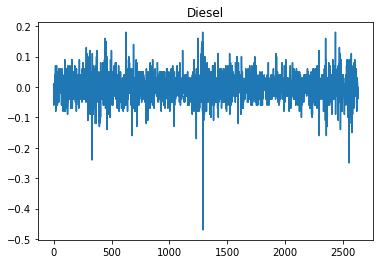

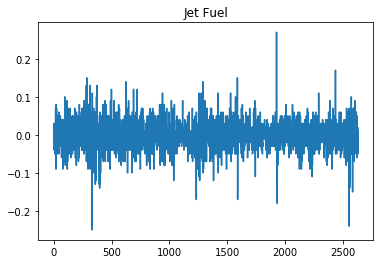

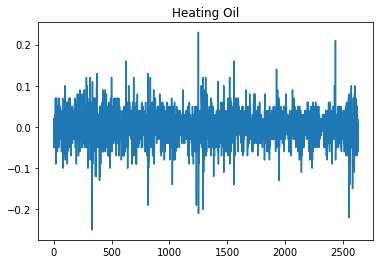

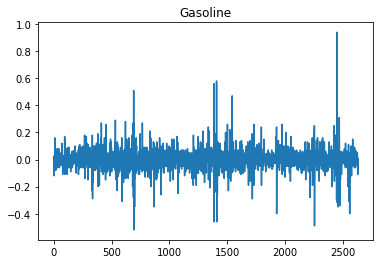

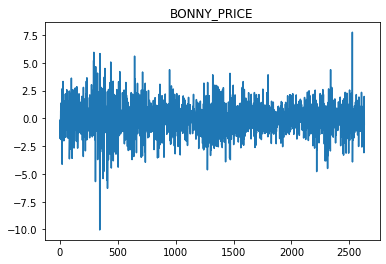

In [12]:
#VISUALISATION OF THE RETURN SERIES OF BONNY VECM MODEL
delta_y_t = bonny_model._delta_y_1_T
labels = ['Diesel', 'Jet Fuel', 'Heating Oil', 'Gasoline', 'BONNY_PRICE']
for g in range(len(['Diesel', 'Jet Fuel', 'Heating Oil', 'Gasoline', 'BONNY_PRICE'])):
    plt.plot(delta_y_t[g])
    plt.title(labels[g])
    plt.show()

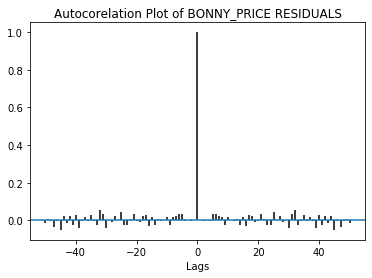

In [13]:
#CHHECKING FOR AUTO CORRELATION IN RESIDUALS OF BONNY VECM MODEL
plt.title('Autocorelation Plot of BONNY_PRICE RESIDUALS')
plt.xlabel('Lags')

plt.acorr(bonny_model.resid[:,4], maxlags=50)
plt.show()


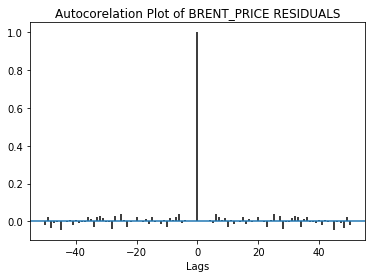

In [14]:
#CHHECKING FOR AUTO CORRELATION IN RESIDUALS OF BRENT'S VECM MODEL
plt.title('Autocorelation Plot of BRENT_PRICE RESIDUALS')
plt.xlabel('Lags')
plt.acorr(brent_model.resid[:,4], maxlags=50)
plt.show()

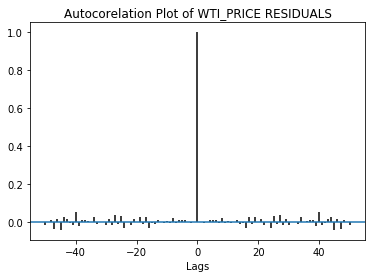

In [15]:
#CHHECKING FOR AUTO CORRELATION IN RESIDUALS OF WTI VECM MODEL
plt.title('Autocorelation Plot of WTI_PRICE RESIDUALS')
plt.xlabel('Lags')
plt.acorr(wti_model.resid[:,4], maxlags=50)
plt.show()

In [79]:
wti_model.alpha

array([[-0.07957289,  0.05903412,  0.01437553,  0.00782904],
       [-0.00467187, -0.01925016,  0.02316765,  0.00207895],
       [ 0.03057493,  0.0608697 , -0.08391234, -0.01099418],
       [-0.04110116,  0.06543511,  0.01579354, -0.04450337],
       [ 0.98275899, -0.86859332,  0.48697966, -0.13470502]])